# PDEFIND Feature Overview
SINDy was originally used to discover systems of ordinary differential equations (ODEs) but was quickly extended to search partial differential equations (PDEs), since many systems exhibit dependence in both space and time. 

This notebook provides a simple overview of the PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614.). Jupyter notebook written by Alan Kaptanoglu.

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.5.1?filepath=examples/10_PDEFIND_examples.ipynb)

In [1]:
import timeit
start = timeit.default_timer()

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-15

# Define Algorithm 2 from Rudy et al. (2017) 
Algorithm 2 is implemented here for scanning the thresholds passed to our STLSQ optimizer (which actually defaults to Ridge Regression with the $l_0$ norm). This tends to result in stronger performance on the below examples. Note that Algorithm 2 is actually in the supplementary materials of the PDE-FIND paper. We don't use this function in the below examples but provide it so users can apply it elsewhere.

In [3]:
# Algorithm to scan over threshold values during Ridge Regression, and select
# highest performing model on the test set


def rudy_algorithm2(
    x_train,
    xdot_train,
    x_test,
    pde_lib,
    dtol,
    alpha=1e-5,
    tol_iter=25,
    normalize_columns=True,
    optimizer_max_iter=20,
    optimization="STLSQ",
):

    # Do an initial least-squares fit to get an initial guess of the coefficients
    optimizer = ps.STLSQ(
        threshold=0,
        alpha=0,
        max_iter=optimizer_max_iter,
        normalize_columns=normalize_columns,
        ridge_kw={"tol": 1e-10},
    )

    # Compute initial model
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(x_train, x_dot=xdot_train)

    # Set the L0 penalty based on the condition number of Theta
    l0_penalty = 1e-3 * np.linalg.cond(optimizer.Theta)
    coef_best = optimizer.coef_

    # Compute MSE on the testing x_dot data (takes x_test and computes x_dot_test)
    error_best = model.score(
        x_test, metric=mean_squared_error, squared=False
    ) + l0_penalty * np.count_nonzero(coef_best)

    coef_history_ = np.zeros((coef_best.shape[0], coef_best.shape[1], 1 + tol_iter))
    error_history_ = np.zeros(1 + tol_iter)
    coef_history_[:, :, 0] = coef_best
    error_history_[0] = error_best
    tol = dtol

    # Loop over threshold values, note needs some coding if not using STLSQ optimizer
    for i in range(tol_iter):
        if optimization == "STLSQ":
            optimizer = ps.STLSQ(
                threshold=tol,
                alpha=alpha,
                max_iter=optimizer_max_iter,
                normalize_columns=normalize_columns,
                ridge_kw={"tol": 1e-10},
            )
        model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
        model.fit(x_train, x_dot=xdot_train)
        coef_new = optimizer.coef_
        coef_history_[:, :, i + 1] = coef_new
        error_new = model.score(
            x_test, metric=mean_squared_error, squared=False
        ) + l0_penalty * np.count_nonzero(coef_new)
        error_history_[i + 1] = error_new
        # If error improves, set the new best coefficients
        if error_new <= error_best:
            error_best = error_new
            coef_best = coef_new
            tol += dtol
        else:
            tol = max(0, tol - 2 * dtol)
            dtol = 2 * dtol / (tol_iter - i)
            tol += dtol
    return coef_best, error_best, coef_history_, error_history_

### Using the new PDE library functionality is straightforward
The only required parameters are the functions to apply to the data (library_functions) and the spatial points where the data was sampled (spatial_grid). However, providing function names (function_names) greatly improves readability, and there are a number of other optional parameters to pass to the library.

In [4]:
# basic data to illustrate the PDE Library
t = np.linspace(0, 10)
x = np.linspace(0, 10)
u = np.ones((len(x) * len(t), 2))

# Define PDE library that is quadratic in u, and second-order in spatial derivatives of u.
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=x,
).fit(u)
pde_lib.transform(u)
print("2nd order derivative library: ")
print(pde_lib.get_feature_names())

# Define PDE library that is quadratic in u, and second-order in spatial derivatives of u.
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
).fit(u)
pde_lib.transform(u)
print("2nd order derivative library with function names: ")
print(pde_lib.get_feature_names(), "\n")

# Now put in a bias term and try 4th order derivatives
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
).fit(u)
pde_lib.transform(u)
print("4th order derivative library: ")
print(pde_lib.get_feature_names(), "\n")

# Default is that mixed derivative/non-derivative terms are returned
# but we change that behavior with include_interaction=False
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    include_interaction=False,
).fit(u)
pde_lib.transform(u)
print("4th order derivative library, no mixed terms: ")
print(pde_lib.get_feature_names())


2nd order derivative library: 
['f0(x0)', 'f0(x1)', 'f1(x0)', 'f1(x1)', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'f0(x0)x0_1', 'f0(x0)x1_1', 'f0(x1)x0_1', 'f0(x1)x1_1', 'f1(x0)x0_1', 'f1(x0)x1_1', 'f1(x1)x0_1', 'f1(x1)x1_1', 'f0(x0)x0_11', 'f0(x0)x1_11', 'f0(x1)x0_11', 'f0(x1)x1_11', 'f1(x0)x0_11', 'f1(x0)x1_11', 'f1(x1)x0_11', 'f1(x1)x1_11']
2nd order derivative library with function names: 
['x0', 'x1', 'x0x0', 'x1x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x0x0_1', 'x0x1_1', 'x1x0_1', 'x1x1_1', 'x0x0x0_1', 'x0x0x1_1', 'x1x1x0_1', 'x1x1x1_1', 'x0x0_11', 'x0x1_11', 'x1x0_11', 'x1x1_11', 'x0x0x0_11', 'x0x0x1_11', 'x1x1x0_11', 'x1x1x1_11'] 

4th order derivative library: 
['1', 'x0', 'x1', 'x0x0', 'x1x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x0_111', 'x1_111', 'x0_1111', 'x1_1111', 'x0x0_1', 'x0x1_1', 'x1x0_1', 'x1x1_1', 'x0x0x0_1', 'x0x0x1_1', 'x1x1x0_1', 'x1x1x1_1', 'x0x0_11', 'x0x1_11', 'x1x0_11', 'x1x1_11', 'x0x0x0_11', 'x0x0x1_11', 'x1x1x0_11', 'x1x1x1_11', 'x0x0_111', 'x0x1_111', 'x1x0_111', '

# Test PDE functionality on the 1D kdV equation
The kdV equation is
$u_t = -6uu_x - u_{xxx}$,
and the data we will be investigating is a two-soliton solution.

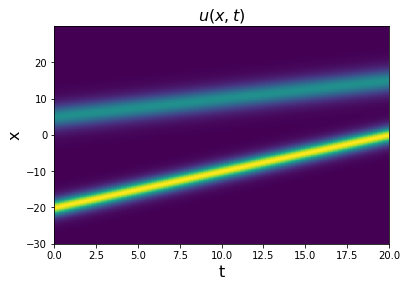

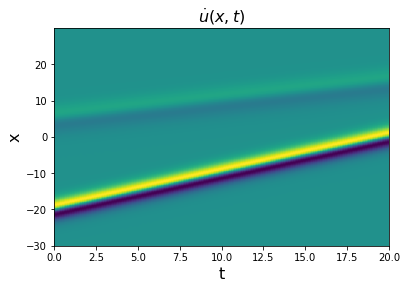

In [5]:
# Load the data stored in a matlab .mat file
kdV = loadmat('data/kdv.mat')
t = np.ravel(kdV['t'])
x = np.ravel(kdV['x'])
u = np.real(kdV['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.figure()
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

# Test spatial derivative computations

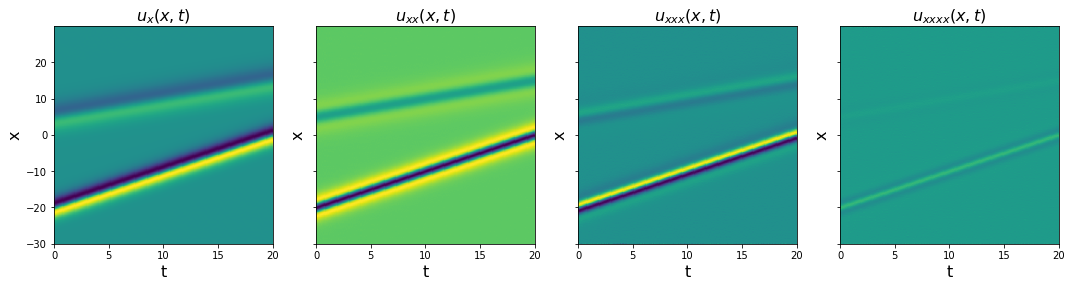

In [6]:
dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0)._differentiate(u, dx)
uxxxx = ps.FiniteDifference(d=4, axis=0)._differentiate(u, dx)
    
# Plot derivative results
plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.pcolormesh(t, x, ux)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u_x(x, t)$', fontsize=16)
plt.subplot(1, 4, 2)
plt.pcolormesh(t, x, uxx)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 3)
plt.pcolormesh(t, x, uxxx)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 4)
plt.pcolormesh(t, x, uxxxx)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxxx}(x, t)$', fontsize=16)
plt.show()

Note that the features get sharper and sharper in the higher-order derivatives, and any noise will be significantly amplified. Now:
### Randomly choose 80% of the time points for training, remaining points for testing, then solve with different optimizers

In [7]:
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
u_dot_train = u_dot[:, train]
u_dot_test = u_dot[:, test]
t_train = t[train]
t_test = t[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_dot_train_flattened = np.reshape(u_dot_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))
u_dot_test_flattened = np.reshape(u_dot_test, (len(x) * len(t_test), 1))

# Define PDE library that is quadratic in u, and third-order in spatial derivatives of u.
# Also, include a constant term (include_bias=True).
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=3, spatial_grid=x, 
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15, 
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

STLSQ model: 
(x0)' = -0.988 x0_111 + -5.956 x0x0_1
SR3 model, L0 norm: 
(x0)' = -0.988 x0_111 + -5.956 x0x0_1
SR3 model, L1 norm: 
(x0)' = -0.080 x0_1 + -0.905 x0_111 + -5.457 x0x0_1
SSR model: 
(x0)' = -0.065 x0_1 + -0.903 x0_111 + -5.606 x0x0_1 + 0.306 x0x0x0_11
SSR (metric = model residual) model: 
(x0)' = -0.065 x0_1 + -0.903 x0_111 + -5.606 x0x0_1 + 0.306 x0x0x0_11
FROLs model: 
(x0)' = -0.080 x0_1 + -0.905 x0_111 + -5.457 x0x0_1


Note that improvements can be found by scanning over kappa until SSR and FROLs produce better models. But this highlights the liability of these greedy algorithms... they have weak and local convergence guarantees so for some problems they "make mistakes" as the algorithm iterations proceed.

# Test PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$. We will repeat all the same steps

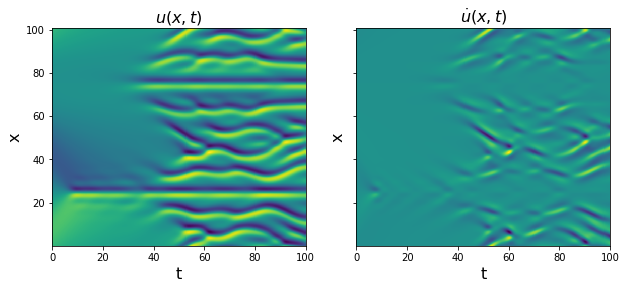

In [8]:
# Load data from .mat file
data = loadmat('data/kuramoto_sivishinky.mat')
t = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [9]:
# Usually, randomly assign 60% of time points to training and remainder to testing
# But for the plot later we want to just use the first 60% of the data

# train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
train = range(0, int(len(t) * 0.6))
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
u_dot_train = u_dot[:, train]
u_dot_test = u_dot[:, test]
t_train = t[train]
t_test = t[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_dot_train_flattened = np.reshape(u_dot_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))
u_dot_test_flattened = np.reshape(u_dot_test, (len(x) * len(t_test), 1))

# Define PDE library that is quadratic in u, and fourth-order in spatial derivatives of u.
# Also, include a constant term (include_bias=True).
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
)

# Again, loop through all the optimizers
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=10, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()
u_dot_stlsq = model.predict(u_test_flattened)

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=7,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=1, max_iter=10000, tol=1e-15, thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=1e1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", normalize_columns=True, kappa=1e1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-4)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

STLSQ model: 


/Users/alankaptanoglu/pysindy/pysindy/differentiation/finite_difference.py:63: UserWarning: Finite differences of arbitrary order are permitted but please note that d >= 4 finite differences will dramatically amplify any numerical noise.
  "Finite differences of arbitrary order are permitted"


(x0)' = -0.992 x0_11 + -0.997 x0_1111 + -0.983 x0x0_1
SR3 model, L0 norm: 
(x0)' = -0.992 x0_11 + -0.997 x0_1111 + -0.983 x0x0_1
SR3 model, L1 norm: 


/Users/alankaptanoglu/pysindy/pysindy/differentiation/finite_difference.py:63: UserWarning: Finite differences of arbitrary order are permitted but please note that d >= 4 finite differences will dramatically amplify any numerical noise.
  "Finite differences of arbitrary order are permitted"
/Users/alankaptanoglu/pysindy/pysindy/differentiation/finite_difference.py:63: UserWarning: Finite differences of arbitrary order are permitted but please note that d >= 4 finite differences will dramatically amplify any numerical noise.
  "Finite differences of arbitrary order are permitted"


(x0)' = -0.986 x0_11 + -0.996 x0_1111 + -0.983 x0x0_1 + -0.002 x0x0x0_111
SSR model: 


/Users/alankaptanoglu/pysindy/pysindy/differentiation/finite_difference.py:63: UserWarning: Finite differences of arbitrary order are permitted but please note that d >= 4 finite differences will dramatically amplify any numerical noise.
  "Finite differences of arbitrary order are permitted"


(x0)' = -0.986 x0_11 + -0.996 x0_1111 + -0.983 x0x0_1 + -0.002 x0x0x0_111
SSR (metric = model residual) model: 


/Users/alankaptanoglu/pysindy/pysindy/differentiation/finite_difference.py:63: UserWarning: Finite differences of arbitrary order are permitted but please note that d >= 4 finite differences will dramatically amplify any numerical noise.
  "Finite differences of arbitrary order are permitted"


(x0)' = -0.986 x0_11 + -0.996 x0_1111 + -0.983 x0x0_1 + -0.002 x0x0x0_111
FROLs model: 


/Users/alankaptanoglu/pysindy/pysindy/differentiation/finite_difference.py:63: UserWarning: Finite differences of arbitrary order are permitted but please note that d >= 4 finite differences will dramatically amplify any numerical noise.
  "Finite differences of arbitrary order are permitted"


(x0)' = -0.992 x0_11 + -0.997 x0_1111 + -0.983 x0x0_1


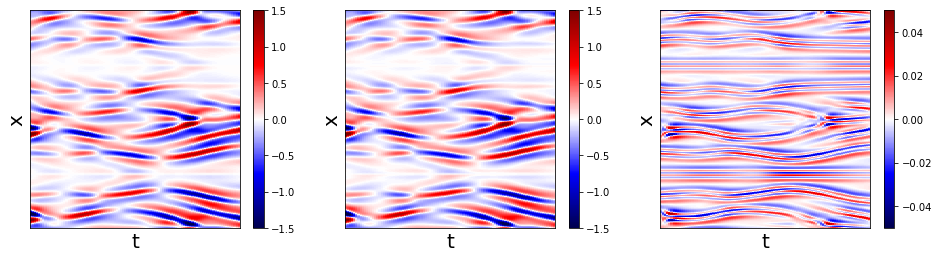

In [10]:
# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(t_test, x, u_dot_test, 
               cmap='seismic', vmin=-1.5, vmax=1.5)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

plt.subplot(1, 3, 2)
u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
plt.pcolormesh(t_test, x, u_dot_stlsq, 
               cmap='seismic', vmin=-1.5, vmax=1.5)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

plt.subplot(1, 3, 3)
plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, 
               cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('KS_ut_comparison.png')

Interestingly, all the models perform quite well on the KS equation. Below, we test our methods on one more 1D PDE, the famous Burgers' equation, before moving on to more advanced examples in 2D and 3D PDEs.

# Test PDE functionality on Burgers' equation
Burgers' equation is
$u_t = -uu_x + 0.1 u_{xx}$. We will repeat all the same steps

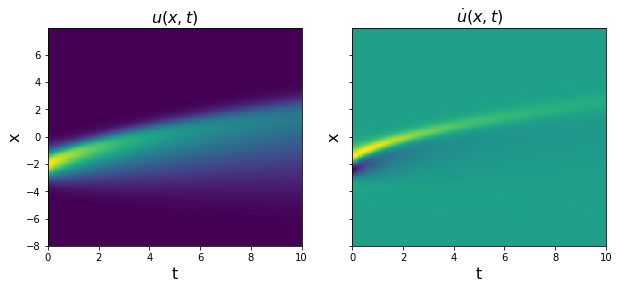

In [11]:
# Load data from .mat file
data = loadmat('data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [12]:
# Randomly assign 80% of time points to training and remainder to testing
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
u_dot_train = u_dot[:, train]
u_dot_test = u_dot[:, test]
t_train = t[train]
t_test = t[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_dot_train_flattened = np.reshape(u_dot_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))
u_dot_test_flattened = np.reshape(u_dot_test, (len(x) * len(t_test), 1))

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.5, max_iter=10000, tol=1e-15, thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual", normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SR3 model, L0 norm: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SR3 model, L1 norm: 
(x0)' = -0.001 x0_1 + 0.100 x0_11 + -1.000 x0x0_1
SSR model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SSR (metric = model residual) model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
FROLs model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1


# Test PDE functionality on 2D Reaction-Diffusion system
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. We will also need to generate the data because saving a high-resolution form of the data makes a fairly large file.

In [13]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'RK45'
integrator_keywords['atol'] = 1e-12

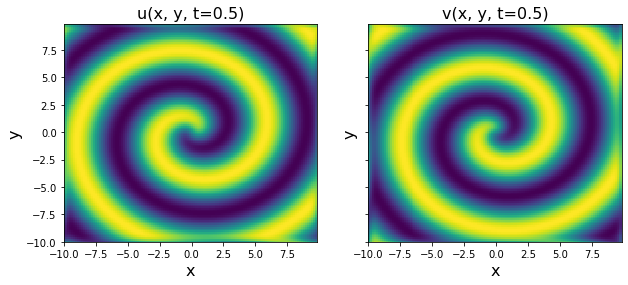

In [14]:
from numpy.fft import fft2, ifft2

# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
# use n = 32 for speed but then the high-order derivatives are terrible
n = 128  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(-n2, -1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u[:, :, 0]), (1, N)), np.reshape(fft2(v[:, :, 0]), (1, N)))
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, 
    args=(K22, d1, d2, beta, n, N), **integrator_keywords
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, t=0.5)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, t=0.5)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [15]:
# Compute u_t from generated solution
u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol
u_dot = ps.FiniteDifference(axis=2)._differentiate(u, dt)

# Choose 60 % of data for training because data is big
train = np.random.choice(len(t), int(len(t) * 0.6), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, :, train, :]
u_test = u[:, :, test, :]
u_dot_train = u_dot[:, :, train, :]
u_dot_test = u_dot[:, :, test, :]
t_train = t[train]
t_test = t[test]
spatial_grid = np.asarray([X, Y]).T

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (N * len(t_train), 2))
u_dot_train_flattened = np.reshape(u_dot_train, (N * len(t_train), 2))
u_test_flattened = np.reshape(u_test, (N * len(t_test), 2))
u_dot_test_flattened = np.reshape(u_dot_test, (N * len(t_test), 2))

In [16]:
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
)
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()
u_dot_stlsq = model.predict(u_test_flattened)

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=60,
    max_iter=10000,
    tol=1e-15,
    nu=1,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()
u_dot_sr3 = model.predict(u_test_flattened)

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=40,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l1",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

print('Constrained SR3 model, L0 norm: ')
feature_names = np.asarray(model.get_feature_names())
n_features = len(feature_names)
n_targets = u_train_flattened.shape[1]
constraint_rhs = np.zeros(2)
constraint_lhs = np.zeros((2, n_targets * n_features))
# (u_xx coefficient) - (u_yy coefficient) = 0
constraint_lhs[0, 11] = 1
constraint_lhs[0, 15] = -1
# (v_xx coefficient) - (v_yy coefficient) = 0
constraint_lhs[1, n_features + 11] = 1
constraint_lhs[1, n_features + 15] = -1
optimizer = ps.ConstrainedSR3(
    threshold=.05,
    max_iter=400,
    tol=1e-10,
    nu=1,
    thresholder="l0",
    normalize_columns=False,
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()
u_dot_constrained_sr3 = model.predict(u_test_flattened)


STLSQ model: 
(x0)' = 0.973 x0 + -0.976 x0x0x0 + 1.000 x1x1x1 + -0.976 x0x1x1 + 0.999 x0x0x1 + 0.096 x0_22 + 0.095 x0_11
(x1)' = 0.973 x1 + -1.000 x0x0x0 + -0.976 x1x1x1 + -0.999 x0x1x1 + -0.976 x0x0x1 + 0.095 x1_22 + 0.096 x1_11
SR3 model, L0 norm: 


/Users/alankaptanoglu/pysindy/pysindy/optimizers/sr3.py:324: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  ConvergenceWarning,


(x0)' = 0.973 x0 + -0.976 x0x0x0 + 1.000 x1x1x1 + -0.976 x0x1x1 + 0.999 x0x0x1 + 0.096 x0_22 + 0.095 x0_11
(x1)' = 0.973 x1 + -1.000 x0x0x0 + -0.976 x1x1x1 + -0.999 x0x1x1 + -0.976 x0x0x1 + 0.095 x1_22 + 0.096 x1_11
SR3 model, L1 norm: 
(x0)' = 0.973 x0 + -0.976 x0x0x0 + 1.000 x1x1x1 + -0.976 x0x1x1 + 0.999 x0x0x1 + 0.096 x0_22 + 0.095 x0_11
(x1)' = 0.973 x1 + -1.000 x0x0x0 + -0.976 x1x1x1 + -0.999 x0x1x1 + -0.976 x0x0x1 + 0.095 x1_22 + 0.096 x1_11
Constrained SR3 model, L0 norm: 
(x0)' = 0.733 x0 + 0.144 x1 + -0.740 x0x0x0 + 0.840 x1x1x1 + -0.741 x0x1x1 + 0.840 x0x0x1 + 0.085 x0_22 + 0.053 x0_1 + 0.053 x0_11 + -0.057 x0x1_2 + -0.163 x0x0x0x0_2 + 0.071 x1x1x1x1_2 + 0.065 x1x0_22 + -0.159 x1x1_22 + 0.064 x0x1x1x1_22 + -0.085 x1x1_1 + -0.071 x0x0x1x0_1 + 0.124 x0x0x1x1_1 + 0.101 x0x0x0x0_12 + 0.083 x0x0x0x1_12 + 0.131 x0x1x1x0_12 + -0.356 x0x1x1x1_12 + -0.088 x0x0x1x1_12 + -0.059 x0x0_11 + -0.429 x1x1x1x0_11
(x1)' = 0.957 x1 + -1.003 x0x0x0 + -0.958 x1x1x1 + -1.003 x0x1x1 + -0.958 x0x0x1

In [17]:
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened, ensemble=True,n_subset=100,replace=False,n_models=1)
model.print()
u_dot_stlsq = model.predict(u_test_flattened)

STLSQ model: 
(x0)' = 0.972 x0 + -0.974 x0x0x0 + 1.000 x1x1x1 + -0.974 x0x1x1 + 0.999 x0x0x1 + 0.097 x0_22 + 0.095 x0_11
(x1)' = 0.972 x1 + -1.000 x0x0x0 + -0.974 x1x1x1 + -0.999 x0x1x1 + -0.974 x0x0x1 + 0.095 x1_22 + 0.097 x1_11


#### Takeaway: most of the optimizers can do a decent job of identifying the true system. 
We skipped the greedy algorithms so this doesn't run for too long. The constrained algorithm does okay, and correctly holds the constraints, but performance is limited currently because normalize_columns = True is crucial for performance here, but is not (currently) compatible with constraints. 

### Below, we show that ensemble methods can generate excellent model identifications on 1/3 the temporal data. 

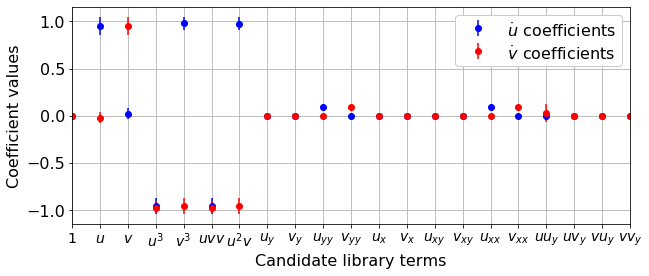

In [18]:
# Show boosting functionality with 2D PDEs where 1/3 the temporal data is used
optimizer = ps.STLSQ(threshold=40, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened, 
          ensemble=True, n_models=10, n_subset=len(t_train) // 3)
xticknames = model.get_feature_names()
num_ticks = len(xticknames)

# Plot boosting results with error bars
mean_coefs = np.mean(model.coef_list, axis=0)
std_coefs = np.std(model.coef_list, axis=0)
colors = ['b', 'r', 'k']
feature_names = ['u', 'v']
plt.figure(figsize=(10, 4))
for i in range(mean_coefs.shape[0]):
    plt.errorbar(range(mean_coefs.shape[1]), mean_coefs[i, :], yerr=std_coefs[i, :], 
                 fmt='o', color=colors[i], label='$\dot ' + feature_names[i] + '_{}$' + ' coefficients')
ax = plt.gca()
ax.set_xticks(range(num_ticks))
for i in range(num_ticks):
    xticknames[i] = '$' + xticknames[i] + '$'
    xticknames[i] = xticknames[i].replace('x0', 'u')
    xticknames[i] = xticknames[i].replace('x1', 'v')
    xticknames[i] = xticknames[i].replace('_11', '_{xx}')
    xticknames[i] = xticknames[i].replace('_12', '_{xy}')
    xticknames[i] = xticknames[i].replace('_22', '_{yy}')
    xticknames[i] = xticknames[i].replace('_1', '_x')
    xticknames[i] = xticknames[i].replace('_2', '_y')
    xticknames[i] = xticknames[i].replace('uuu', 'u^3')
    xticknames[i] = xticknames[i].replace('uuv', 'u^2v')
    xticknames[i] = xticknames[i].replace('uuv', 'uv^2')
    xticknames[i] = xticknames[i].replace('vvv', 'v^3')

ax.set_xticklabels(xticknames)
plt.legend(fontsize=16, framealpha=1.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Candidate library terms', fontsize=16)
plt.ylabel('Coefficient values', fontsize=16)
plt.xlim(0, 20)
plt.savefig('ensemble_performance.png')

# Test PDE functionality on 3D Reaction-Diffusion system
We will use a 3D reaction-diffusion equation called the Gray-Scott Equation. We are folllowing the example in Section 3.3.3 of Maddu, S., Cheeseman, B. L., Sbalzarini, I. F., & Müller, C. L. (2019). Stability selection enables robust learning of partial differential equations from limited noisy data. arXiv preprint arXiv:1907.07810., https://arxiv.org/pdf/1907.07810.pdf.
$$u_t = D_u\nabla^2 u - uv^2 + 0.014(1-u)$$
$$v_t = D_v\nabla^2 v + uv^2 - 0.067 v$$
We will need to generate some very low-resolution data, because the memory requirements are very significant for a fully 3D problem. We will show below that with this very low-resolution data we can still approximately identify the PDE, but the weak form is required for further improvements (ensembling helps too but it doesn't help the fact that the spatial resolution is so low).

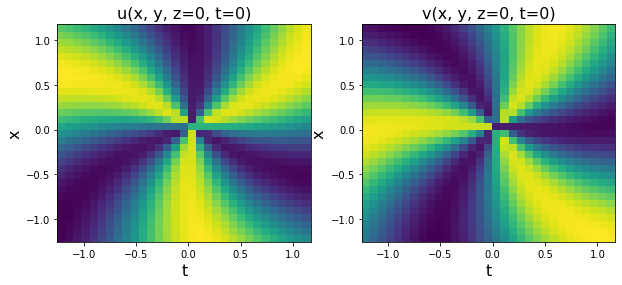

In [19]:
from numpy.fft import fftn, ifftn

# Define the reaction-diffusion PDE in the Fourier (kx, ky, kz) space
def reaction_diffusion(t, uvt, K22, d1, d2, n, N):
    ut = np.reshape(uvt[:N], (n, n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n, n))
    u = np.real(ifftn(ut, axes=[0, 1, 2]))
    v = np.real(ifftn(vt, axes=[0, 1, 2]))
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fftn(0.014 * (1 - u) - uv2, axes=[0, 1, 2])), (N, 1))
    vtrhs = np.reshape((fftn(uv2 - 0.067 * v, axes=[0, 1, 2])), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
dt = 0.1
t = np.linspace(0, 10, int(5 / dt))
d1 = 2e-2
d2 = 1e-2
L = 2.5  # Domain size in X, Y, Z directions

# use n = 32 for speed but then the high-order derivatives are terrible
n = 32  # Number of spatial points in each direction
N = n * n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
z = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky, kz)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(-n2, -1, n2)))
ky = kx
kz = kx
# Get 3D meshes in (x, y, z) and (kx, ky, kz)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
K2 = KX ** 2 + KY ** 2 + KZ ** 2
K22 = np.reshape(K2, (N, 1))

m = 3  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(z), len(t)))
v = np.zeros((len(x), len(y), len(z), len(t)))

# Initial conditions
u[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2 + Z ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2 + Z ** 2))
)
v[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2 + Z ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2 + Z ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (
            np.reshape(fftn(u[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
            np.reshape(fftn(v[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
        )
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, 
    args=(K22, d1, d2, n, N), **integrator_keywords
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, z, t) space from (kx, ky, kz, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n, n))
    vt = np.reshape(uvsol[N:, j], (n, n, n))
    u[:, :, :, j] = np.real(ifftn(ut, axes=[0, 1, 2]))
    v[:, :, :, j] = np.real(ifftn(vt, axes=[0, 1, 2]))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u[:, :, 0, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title('u(x, y, z=0, t=0)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X[:, :, 0], Y[:, :, 0], v[:, :, 0, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title('v(x, y, z=0, t=0)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

u_sol = u
v_sol = v

In [20]:
# Compute u_t from generated solution
u = np.zeros((n, n, n, len(t), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol
u_dot = ps.FiniteDifference(axis=3)._differentiate(u, dt)

train = np.random.choice(len(t), int(len(t) * 0.6), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, :, :, train, :]
u_test = u[:, :, :, test, :]
u_dot_train = u_dot[:, :, :, train, :]
u_dot_test = u_dot[:, :, :, test, :]
t_train = t[train]
t_test = t[test]
spatial_grid = np.asarray([X, Y, Z])
spatial_grid = np.transpose(spatial_grid, [1, 2, 3, 0])

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (N * len(t_train), 2))
u_dot_train_flattened = np.reshape(u_dot_train, (N * len(t_train), 2))
u_test_flattened = np.reshape(u_test, (N * len(t_test), 2))
u_dot_test_flattened = np.reshape(u_dot_test, (N * len(t_test), 2))

In [21]:
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    include_interaction=False,
)

optimizer = ps.SR3(threshold=1, normalize_columns=True, max_iter=5000, tol=1e-10)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()

(x0)' = 0.014 1 + -0.020 x0 + -0.981 x0x1x1 + 0.020 x0_33 + 0.020 x0_22 + 0.020 x0_11
(x1)' = -0.076 x1 + 0.973 x0x1x1 + 0.010 x1_33 + 0.010 x1_22 + 0.009 x1_11


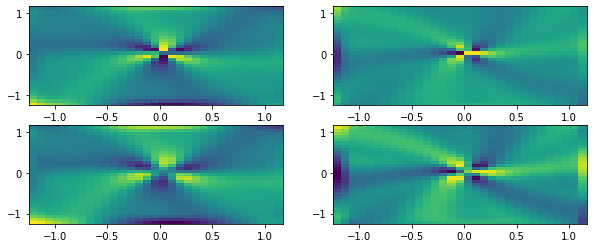

In [22]:
# Plot successful fits!
u_dot = model.predict(u_test_flattened)
u_dot = np.reshape(u_dot, (n, n, n, len(t_test), 2))

plt.figure(figsize=(10, 4))
plt.subplot(2, 2, 1)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u_dot_test[:, :, 0, 1, 0])
plt.subplot(2, 2, 2)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u_dot_test[:, :, 0, 1, 1])
plt.subplot(2, 2, 3)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u_dot[:, :, 0, 1, 0])
plt.subplot(2, 2, 4)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u_dot[:, :, 0, 1, 1])
plt.show()

### Despite the very low resolution, can do quite a decent job with the system identification!
We used only 50 timepoints and a 32 x 32 x 32 spatial mesh, and essentially capture the correct model for a 3D PDE!

In [23]:
stop=timeit.default_timer()
print(stop - start)

597.5920512700001
